# Q1

From the figures below, we can clearly see a multi-stream network that fuses features/predictions across layers. Basically, there are variants of the FCN architecture, which mainly differ in the spatial precision of their output. For example, the figures below show the FCN-32, FCN-16 and FCN-8 variants. In the figures, convolutional layers are represented as vertical lines between pooling layers, which explicitely show the relative size of the feature maps.

As shown below, these 3 different architectures differ in the stride of the last convolution, and the skip connections used to obtain the output segmentation maps. We will use the term downsampling path to refer to the network up to conv7 layer and we will use the term upsampling path to refer to the network composed of all layers after conv7. It is worth noting that the 3 FCN architectures share the same downsampling path, but differ in their respective upsampling paths.

For the model FCN8s, it sums the 2x upsampled conv7 (with a stride 2 transposed convolution) with pool4, upsamples them with a stride 2 transposed convolution and sums them with pool3, and applies a transposed convolution layer with stride 8 on the resulting feature maps to obtain the segmentation map.

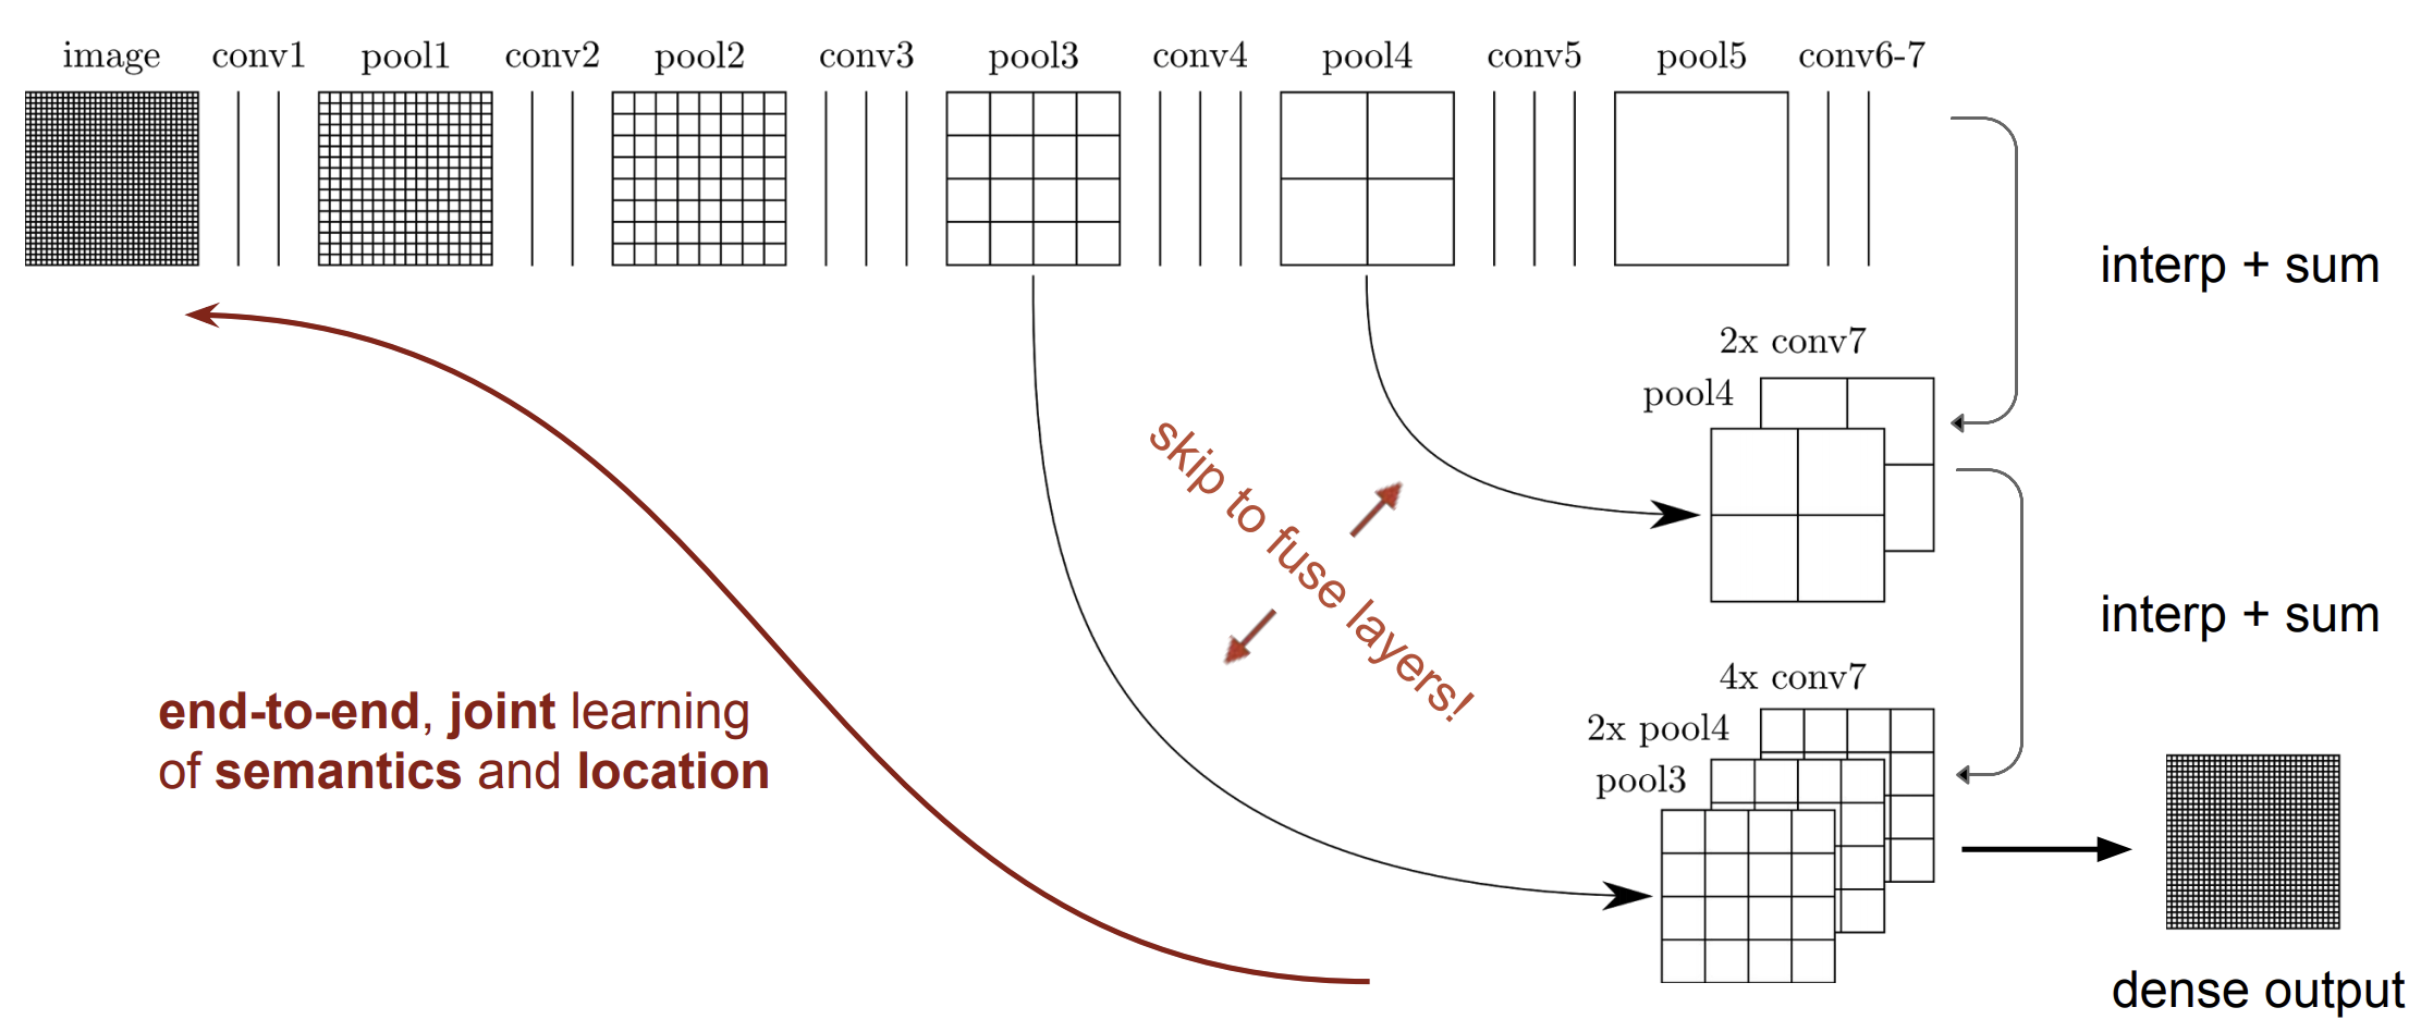

Reference: Jonathan Long, Fully Convolutional Networks for Semantic Segmentation.

# Q2

Yes, we use the weights from Vgg16, so we did not train the model from scratch. 

# Q3

The result from Tensorboard is:
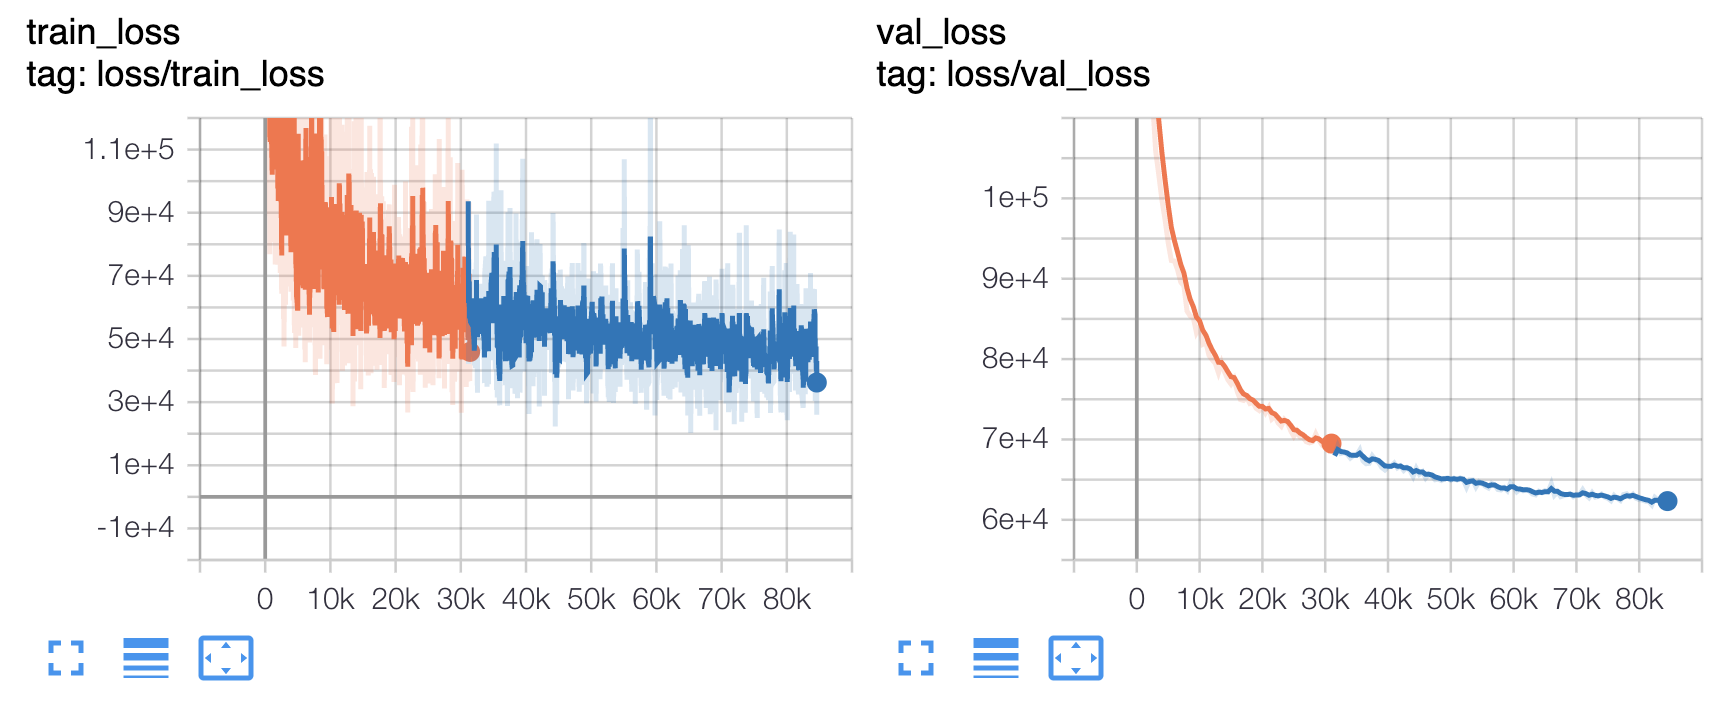

# Q4

Matrics used by original paper:  
·pixel accuracy    
·mean accuraccy    
·mean IU    
·frequency weighted IU

Among all the classes performance:  
·Best: class 0                
·Worst: class 12     

# Q5

In [2]:
%matplotlib notebook

import numpy as np 
import torch
import torch.utils.data as td 
import torchvision as tv
import matplotlib.pyplot as plt 
import torch
import sys
sys.path.insert(0, "hw4data/ece253_pytorch_semseg_hw_design_v3/")

from ptsemseg.loader import cityscapes_loader as city
from ptsemseg.models import fcn
from ptsemseg.models import get_model
from ptsemseg.loader import get_loader
from ptsemseg.metrics import runningScore
from ptsemseg.utils import convert_state_dict
from ptsemseg.utils import recursive_glob
from PIL import Image
import yaml

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Setup Model
with open(r'hw4data/ece253_pytorch_semseg_hw_design_v3/runs/fcn8s_cityscapes/20191212_152316/fcn8s_cityscapes.yml') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    
state_path = 'hw4data/ece253_pytorch_semseg_hw_design_v3/runs/fcn8s_cityscapes/20191212_152316/fcn8s_cityscapes_best_model.pkl'

In [4]:
data_loader = get_loader(cfg["data"]["dataset"])
data_path = cfg["data"]["path"]

t_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["train_split"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"])
)

v_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["val_split"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
)

ts_loader = data_loader(
    data_path, 
    is_transform=True,
    split="test", test_mode=True, 
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"])
)

Found 2975 train images
Found 500 val images
Found 1525 test images


In [5]:
trainloader = td.DataLoader(
        t_loader,
        batch_size=cfg["training"]["batch_size"],
        num_workers=cfg["training"]["n_workers"],
        shuffle=True
    )

valloader = td.DataLoader(
        v_loader, batch_size=cfg["training"]["batch_size"], num_workers=cfg["training"]["n_workers"]
    )

testloader = td.DataLoader(
        ts_loader, batch_size=cfg["training"]["batch_size"], num_workers=cfg["training"]["n_workers"]
    )

In [6]:
n_classes = t_loader.n_classes
bs = cfg["training"]["batch_size"]

model = get_model(cfg['model'], n_classes)
state = convert_state_dict(torch.load(state_path)["model_state"])
model.load_state_dict(state)
model.eval()
model.to(device);

Run this block multiple times to test different image

In [7]:
# 0: visualize train set; 
# 1: visualize validation set; 
# 2: visualize test set
vis_mode = 1

if vis_mode == 0:
    loader, td_loader = t_loader, trainloader
elif vis_mode == 1:
    loader, td_loader = v_loader, valloader
elif vis_mode == 2:
    loader, td_loader = ts_loader, testloader
    
dataiter = iter(td_loader)

WARN: resizing labels yielded fewer classes


In [8]:
def getImg(img_path):
    test_img = Image.open(img_path).convert('RGB')
    transform = tv.transforms.Compose([
        tv.transforms.Resize((cfg["data"]["img_rows"], cfg["data"]["img_cols"])),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
    return transform(test_img).unsqueeze(0)

test_img1 = getImg("hw4data/test1.jpg")
test_img2 = getImg("hw4data/test2.jpg")
test_img3 = getImg("hw4data/test3.jpg")

<IPython.core.display.Javascript object>


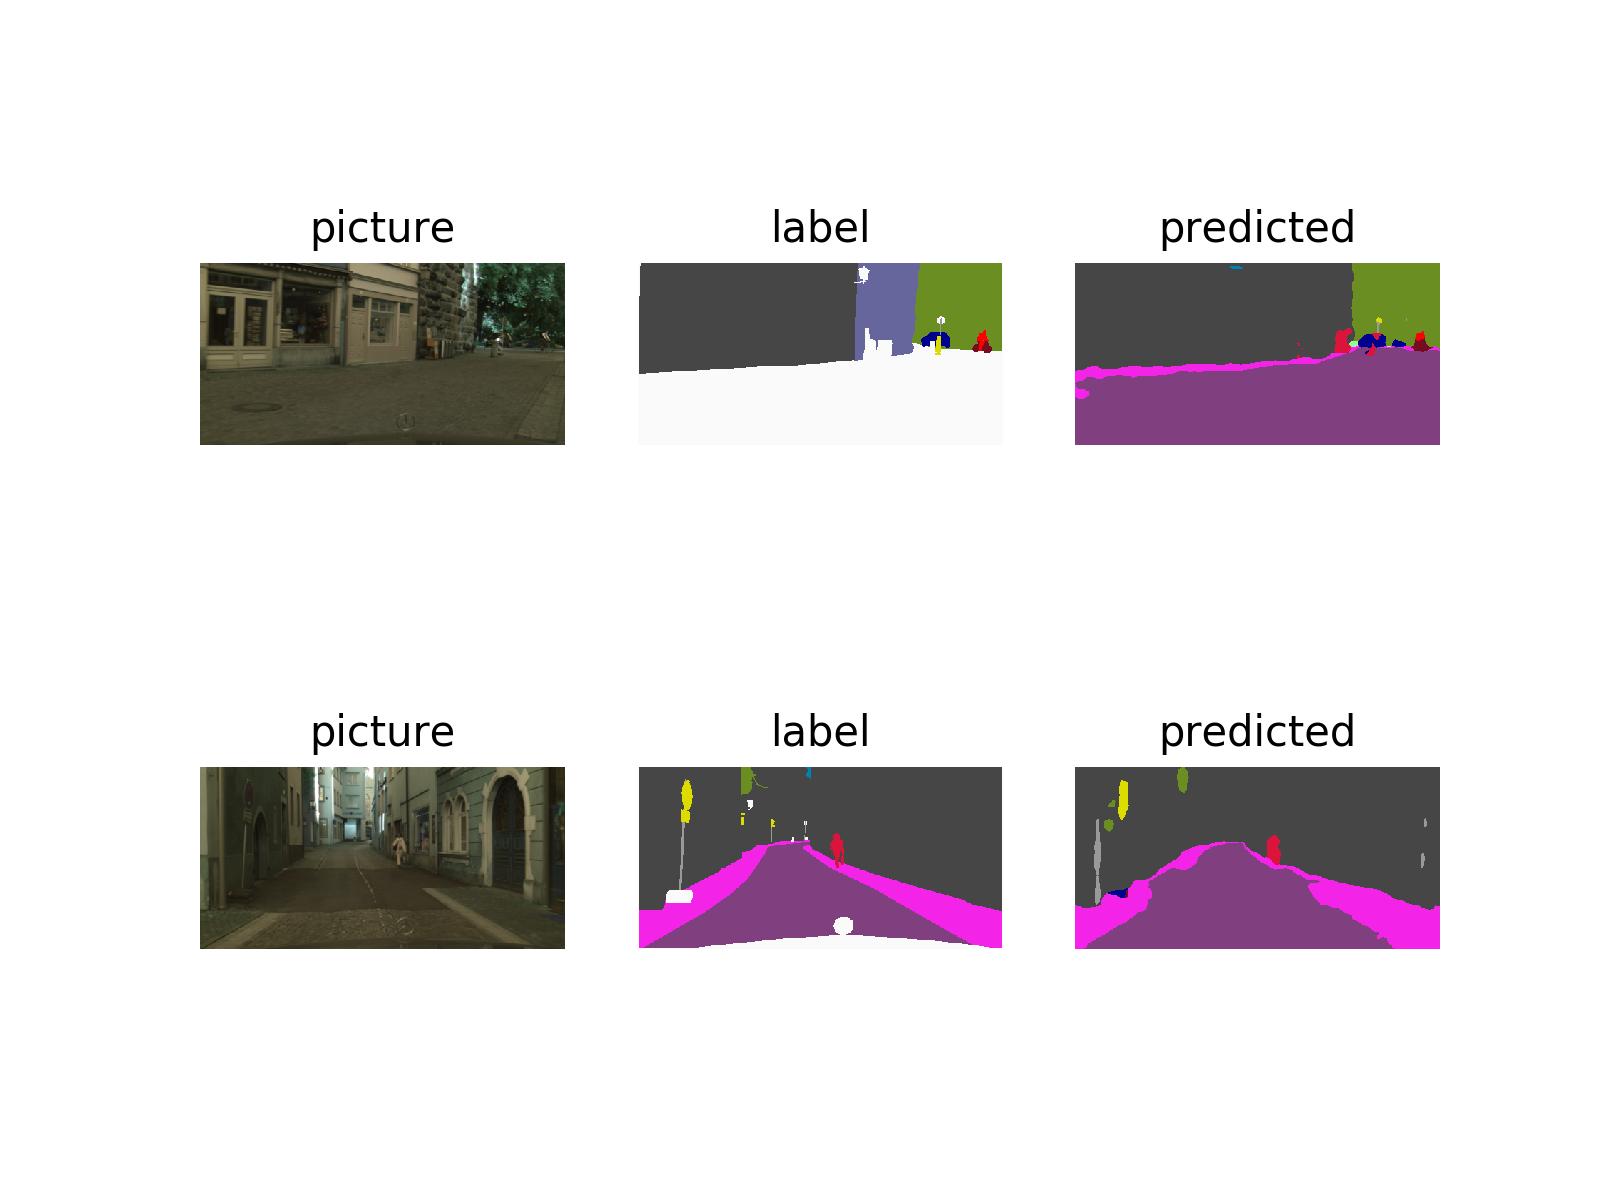

In [9]:
# uncomment to use provided datasets
images, labels = dataiter.next()

# uncomment the follwoing two lines to use self-taken pictures
# images = torch.cat([test_img1, test_img2, test_img3], 0)
# labels = torch.ones([images.shape[0], images.shape[2], images.shape[3]]) * 250

bs = images.shape[0]
imgs = images.to(device, dtype=torch.float)
pred = model(imgs).data.max(1)[1].cpu().numpy()

# show images
f, axarr = plt.subplots(bs, 3)

for j in range(bs):
    toshow = images.numpy()[j]
    toshow = np.moveaxis(toshow, [0, 1, 2], [2, 0, 1]) 
    axarr[j][0].imshow(toshow)
    axarr[j][1].imshow(loader.decode_segmap(labels.numpy()[j]))
    axarr[j][2].imshow(loader.decode_segmap(pred[j]))

    axarr[j][0].axis('off')
    axarr[j][1].axis('off')
    axarr[j][2].axis('off')
    axarr[j][0].set_title('picture')
    axarr[j][1].set_title('label')
    axarr[j][2].set_title('predicted')
plt.show()


# Q6

<IPython.core.display.Javascript object>


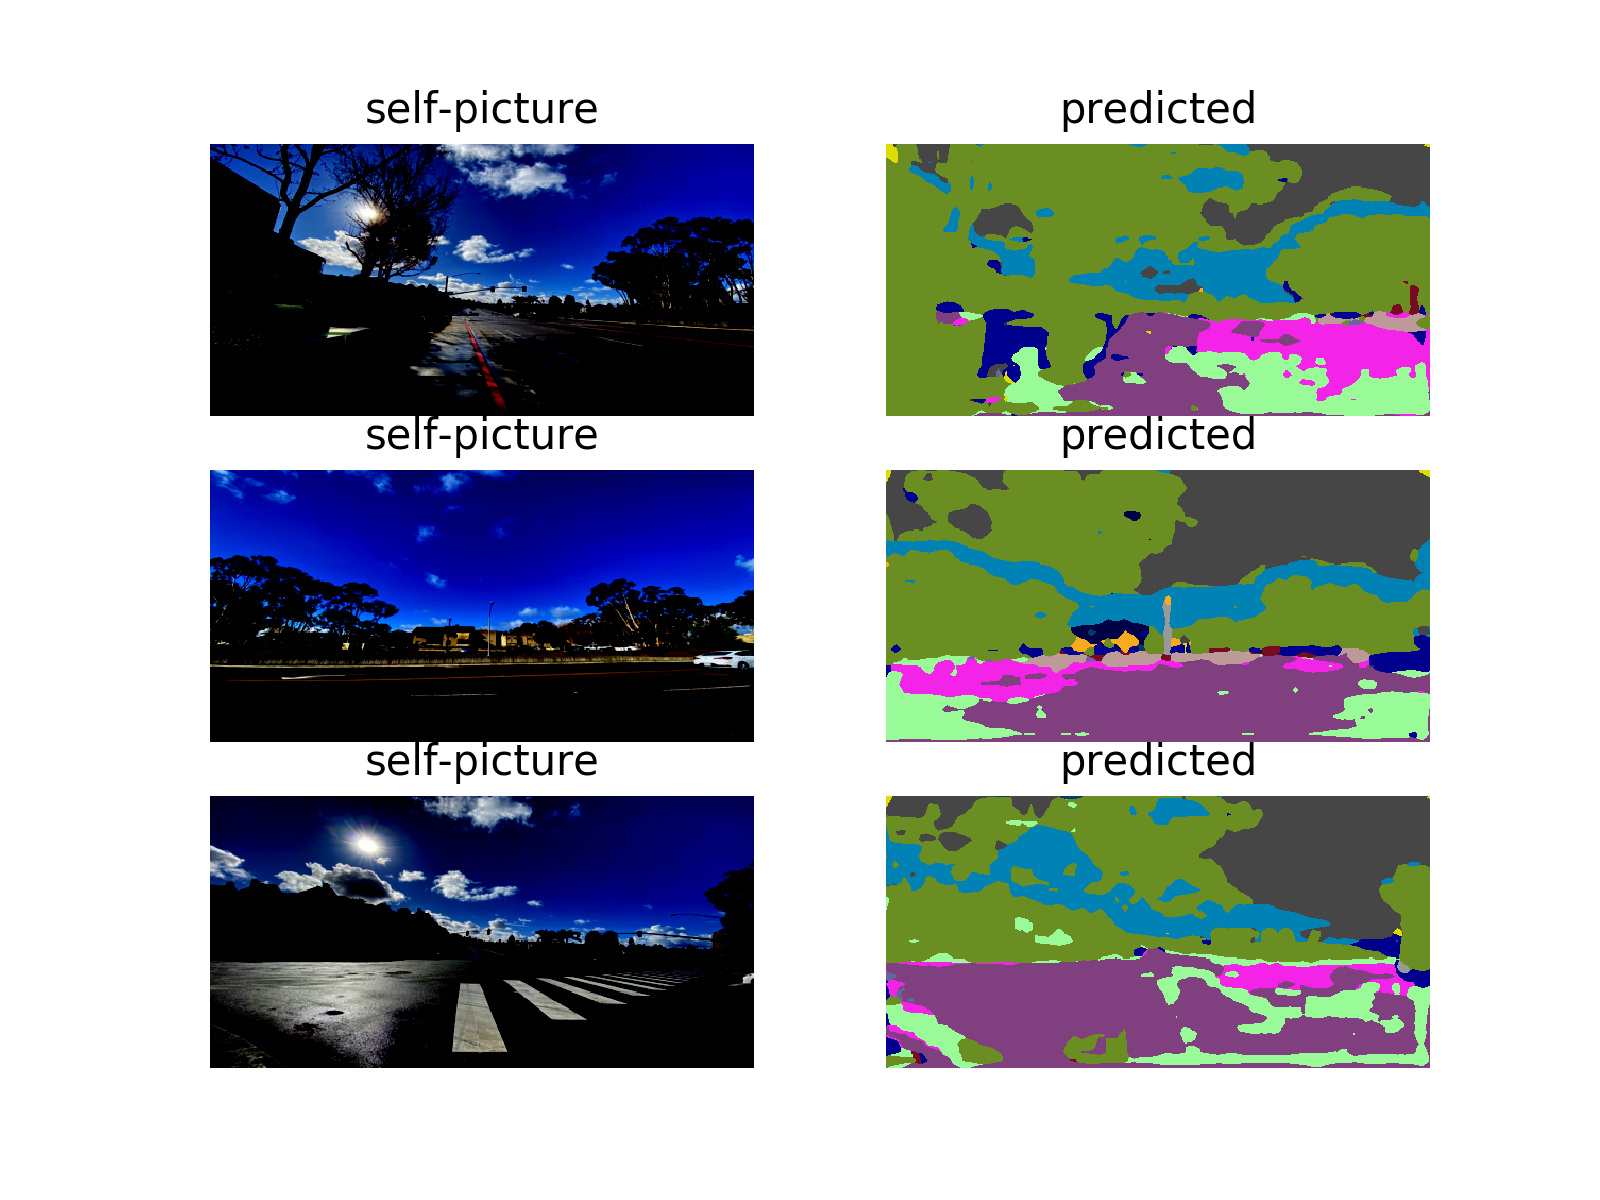

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
images = torch.cat([test_img1, test_img2, test_img3], 0)
labels = torch.ones([images.shape[0], images.shape[2], images.shape[3]]) * 250

bs = images.shape[0]
imgs = images.to(device, dtype=torch.float)
pred = model(imgs).data.max(1)[1].cpu().numpy()

# show images
f, axarr = plt.subplots(bs, 2)

for j in range(bs):
    toshow = images.numpy()[j]
    toshow = np.moveaxis(toshow, [0, 1, 2], [2, 0, 1]) 
    axarr[j][0].imshow(toshow)
    axarr[j][1].imshow(loader.decode_segmap(pred[j]))

    axarr[j][0].axis('off')
    axarr[j][1].axis('off')
    axarr[j][0].set_title('self-picture')
    axarr[j][1].set_title('predicted')
plt.show()


The result looks reasonable.

# Q7

### Improvement 1:                  
The upsampling process would lose some important informaiton. We can process Fully Connected Conditional Random Fields after pixels classification, which can improve the details in figures by post processing.
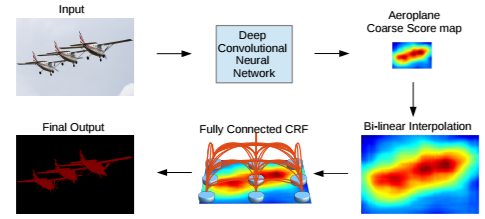

Reference:
Liang-Chieh Chen, Semantic image segmentation with deep convolutional nets and fully connected crfs

### Improvement 2:                      

We can try to achieve our goal by using RNN with CRF, which perform a better result during experiment.
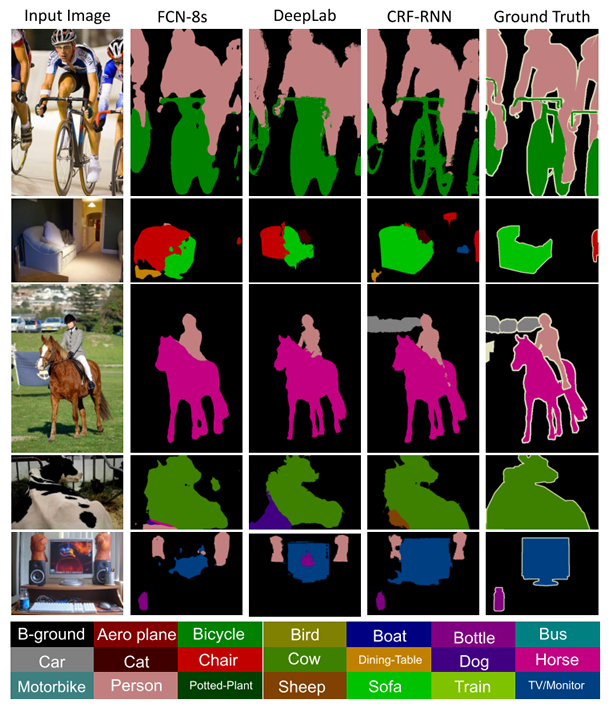

Reference:Shuai Zheng, Conditional random fields as recurrent neural networks

### Improvement 3:              
We can try to use dilated convolution instead of traditional convolution in the paper. In this case, we can increase the receptive fields and retain more information for upsampling.

Reference: Fisher Yu, MULTI-SCALE CONTEXT AGGREGATION BY DILATED CONVOLUTIONS 